### Kaggle competition_ overfitters
Sanaz Kaviani, sanaz.kaviani@umontreal.ca, marticule: 2111567 
Mersede Mokri, mersede.mokri@umontreal.ca, marticule: 2111556
Hamed Naseri, hamed.naseri@polymtl.ca, marticule: 2051414


### In the following part, the required standard libraries are imported, and the preprocessing function is modeled.

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # used to Disable Tensorflow debugging informatio
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from skimage import measure, morphology
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Pre-Processing 


In [ ]:
""" Pre-Processing """
def PreProcessing_1(dataSample, filteredImgSize, binarizingTH):
    dataSize = dataSample.shape[0]               #Number of Examples
    NumPixels = dataSample[0][1].shape[0]       #Original Feature Size which is imageLength*imageWidth
    originalImgSize = np.sqrt(NumPixels).astype(int)   #Original Image Size
    """ Initialization """
    filteredImgCenter = int(filteredImgSize/2)   #Center of the Filtered Image (25 here)
    featureSize = filteredImgSize**2
    processedImageSet = np.zeros((dataSize, featureSize))
    """ First Train Set: to find Vocabs of SIFT, SURF and anyother feature """
    for i in range(dataSize):
        if (i+1)%1000 == 0:
            print(i , ' of data have been processed')
        originalImg = dataSample[i,1].reshape(originalImgSize,originalImgSize)
        originalImg[originalImg > 255] = 255
        binarizedImg = originalImg > binarizingTH  #this needs to be tunned
        origImgSegments= measure.label(binarizedImg, background = 0)
        mostCommonLabel = Counter(origImgSegments.flatten()).most_common(3)
        filterMask = (origImgSegments == mostCommonLabel[1][0]) #+ (origImgSegments ==mostCommonLabel[2][0])
        filteredImg = filterMask * originalImg
        regionImg = measure.regionprops(filterMask.astype(int))[0]
        originalImgCenter = [int(regionImg.bbox[0]+((regionImg.bbox[2]-regionImg.bbox[0])/2)), int(regionImg.bbox[1]+((regionImg.bbox[3]-regionImg.bbox[1])/2))]
        deltaX = regionImg.bbox[2]-regionImg.bbox[0]
        deltaY = regionImg.bbox[3]-regionImg.bbox[1]
        deltaX = int( min(1.5*deltaX , filteredImgSize))
        deltaX += deltaX%2
        deltaY = int( min(1.5*deltaY , filteredImgSize))
        deltaY += deltaY%2
        grabbedImg = []
        grabbedImg = filteredImg[max(0,originalImgCenter[0]-int(deltaX/2)):min(originalImgSize-1,originalImgCenter[0]+int(deltaX/2)), max(0,originalImgCenter[1]-int(deltaY/2)):min(originalImgSize-1,originalImgCenter[1]+int(deltaY/2))]
        tmpXsize = grabbedImg.shape[0]
        tmpYsize = grabbedImg.shape[1]
        tmpImg = np.zeros((filteredImgSize , filteredImgSize))
        tmpImg[filteredImgCenter-int(tmpXsize/2) : filteredImgCenter+int(tmpXsize/2)+tmpXsize%2, filteredImgCenter-int(tmpYsize/2): filteredImgCenter+int(tmpYsize/2)+tmpYsize%2] = grabbedImg
        tmpImgSegments= measure.label(tmpImg>binarizingTH, background = 0)
        mostCommonLabel = Counter(tmpImgSegments.flatten()).most_common()
        finalMask = morphology.remove_small_objects(tmpImg>binarizingTH, min(40, mostCommonLabel[1][1]-1), connectivity=2)
        tmpImg = tmpImg*finalMask
        outImg = tmpImg / np.max(tmpImg)
        processedImageSet[i,:] = outImg.flatten()
    return processedImageSet

Mounted at /content/drive


## Loading Data

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)


"""                    Loading Train and Test Data:                         """
dataTrain = np.load('/content/drive/MyDrive/train_images.npy', encoding='latin1', allow_pickle=True)
dataTest  = np.load('/content/drive/MyDrive/test_images.npy',  encoding = 'latin1', allow_pickle=True)

"""  Extracting Train & Test Sets Sizes and Original Feature & Image Sizes  """
trainSize = dataTrain.shape[0]  # Number of Training Examples
testSize  = dataTest.shape[0]                #Number of Testing Examples

"""    Loading Labels of Train Data & Converting Words to Numeric Labels    """
myCSV = np.genfromtxt('/content/drive/MyDrive/train_labels.csv', delimiter=',', dtype='str')
    # myCSV = np.genfromtxt('./all/train_labels.csv', delimiter=',', dtype = 'str')
trainLabelWords = myCSV[1:, 1]  # Training labels: Words
uniqueLabelWords = np.unique(trainLabelWords)  # Unique Labels
trainLabel = np.zeros((trainSize, 1))  # Training Labels: Numerics
NumberLabel = uniqueLabelWords.shape[0]
refLabel = np.zeros((NumberLabel, 2))
for i in range(NumberLabel):
   trainLabel[trainLabelWords == uniqueLabelWords[i], 0] = i

    

### In the following part, data are initialized and preprocessing process is performed to ehnace the model's accuracy.

In [ ]:
""" Parameter Initialization """
filteredImgSize = 40
binarizingTH = 8  # for first segmentation

processedImgTrain1 = PreProcessing_1(dataTrain, filteredImgSize, binarizingTH)
processedImgTest1 = PreProcessing_1(dataTest, filteredImgSize, binarizingTH)

binarizingTH = 0.01  # range (0,1)
featMatrixTrain = 1 * (processedImgTrain1 > binarizingTH)
featMatrixTest  = 1 * (processedImgTest1>binarizingTH)
featMatrixTrain = featMatrixTrain.astype('float32')
featMatrixTest = featMatrixTest.astype('float32')


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


"""  Extracting Train & Test Sets Sizes and Original Feature & Image Sizes  """
trainSize = featMatrixTrain.shape[0]               #Number of Training Examples
testSize  = featMatrixTest.shape[0]                #Number of Testing Examples
featureSize = featMatrixTrain.shape[1]             #Number of Features


nTrain = int(0.9*trainSize)
idxTrainValid = np.random.choice(trainSize, [trainSize,1],replace = False)

t_train = trainLabel[idxTrainValid[:nTrain],0]
t_valid = trainLabel[idxTrainValid[nTrain:],0]
X_train = featMatrixTrain[idxTrainValid[:nTrain,0],:]
X_valid = featMatrixTrain[idxTrainValid[nTrain:,0],:]
X_test = featMatrixTest

X_train = (X_train.reshape(X_train.shape[0], 1,filteredImgSize, filteredImgSize))
#X_train = np.expand_dims(X_train, axis=-1)
X_valid = (X_valid.reshape(X_valid.shape[0], 1,filteredImgSize, filteredImgSize))
#X_valid = np.expand_dims(X_valid, axis=-1)
X_test = (X_test.reshape(X_test.shape[0], 1,filteredImgSize, filteredImgSize))
#X_test = np.expand_dims(X_test, axis=-1)
    #one-hot encode target column
y_train = to_categorical(t_train)
y_valid = to_categorical(t_valid)

num_classes = y_valid.shape[1]

999  of data have been processed
1999  of data have been processed
2999  of data have been processed
3999  of data have been processed
4999  of data have been processed
5999  of data have been processed
6999  of data have been processed
7999  of data have been processed
8999  of data have been processed
9999  of data have been processed
999  of data have been processed
1999  of data have been processed
2999  of data have been processed
3999  of data have been processed
4999  of data have been processed
5999  of data have been processed
6999  of data have been processed
7999  of data have been processed
8999  of data have been processed
9999  of data have been processed


## Convolutional Neural Network is defined in the following part.

In [ ]:
def CNN_model(filteredImgSize=40):
    model = Sequential([
        # First two convolutional layers
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(1, filteredImgSize, filteredImgSize)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        # normalization layer
        BatchNormalization(),
        # pooling layer
        MaxPooling2D(pool_size=(2, 2)),
        # add regularization
        Dropout(0.25),
        # Second two convolutional layers
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        # normalization layer
        BatchNormalization(),
        # pooling layer
        MaxPooling2D(pool_size=(2, 2)),
        # add regularization
        Dropout(0.25),

        Flatten(),

        # FC layer
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(31, activation='softmax')
    ])
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0004),
                  metrics=['accuracy'])
    return model

# CNN model is run, and its accuracy for training and validation data is reported for each epoch.

Epoch 1/700
300/300 [==============================] - 4s 15ms/step - loss: 3.7987 - accuracy: 0.1499 - val_loss: 14.4877 - val_accuracy: 0.0323
Epoch 2/700
300/300 [==============================] - 4s 13ms/step - loss: 3.2549 - accuracy: 0.2007 - val_loss: 5.5009 - val_accuracy: 0.0697
Epoch 3/700
300/300 [==============================] - 4s 13ms/step - loss: 2.8838 - accuracy: 0.2493 - val_loss: 3.0986 - val_accuracy: 0.2566
Epoch 4/700
300/300 [==============================] - 4s 13ms/step - loss: 2.5910 - accuracy: 0.3036 - val_loss: 2.2047 - val_accuracy: 0.3808
Epoch 5/700
300/300 [==============================] - 4s 13ms/step - loss: 2.3286 - accuracy: 0.3596 - val_loss: 2.1884 - val_accuracy: 0.3657
Epoch 6/700
300/300 [==============================] - 4s 13ms/step - loss: 2.1957 - accuracy: 0.3824 - val_loss: 2.1805 - val_accuracy: 0.4111
Epoch 7/700
300/300 [==============================] - 4s 13ms/step - loss: 2.1040 - accuracy: 0.4047 - val_loss: 1.8079 - val_accuracy

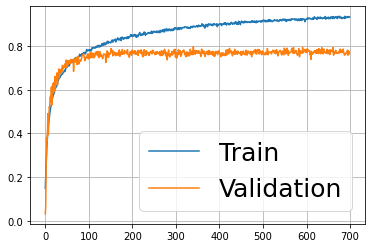

In [ ]:
from keras import backend as K
K.set_image_data_format('channels_first')

modelBest=CNN_model()

batch_size=35
epoch_aug1=700

#earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=30, verbose=0, mode='min')

gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.3, 
                         height_shift_range=0.1, zoom_range=0.1)



batches = gen.flow(X_train, y_train, batch_size=batch_size)
val_batches = gen.flow(X_valid, y_valid, batch_size=batch_size)
     

results=modelBest.fit_generator(batches, steps_per_epoch=X_train.shape[0] // batch_size, epochs=epoch_aug1,
                                validation_data=val_batches, validation_steps=X_valid.shape[0] // batch_size,
                                use_multiprocessing=False)


#results = modelBest.fit_generator(X, Y, validation_split=0.1, batch_size=55, epochs=100)

plt.figure()
plt.plot(results.history['accuracy'], label="Train")
plt.plot(results.history['val_accuracy'], label="Validation")
plt.legend(fontsize=25)
plt.grid(True)
plt.show()


# The final accuracy of CNN for training and validation data is reported in the following part.
scores = modelBest.evaluate(X_train, y_train, verbose=1)
print("Large CNN Train Error: %.2f%%" % (100-scores[1]*100))
scores = modelBest.evaluate(X_valid, y_valid, verbose=1)
print("Large CNN Valid Error: %.2f%%" % (100-scores[1]*100))



#predict images in the test set
y_test_CNN = modelBest.predict(X_test)
t_test_CNN = np.argmax(y_test_CNN,axis=1)

testLabelCNN = np.zeros((testSize,2)).astype('str')

# map the predict result to classes name
for i in range(NumberLabel):
  testLabelCNN[t_test_CNN == i,1] = uniqueLabelWords[i]

testLabelCNN[:,0]=range(10000)

# The testing data labels are predicted in the following part, and the predicted labels are saved in a csv file in order to be uploaded in Kaggle website.  
test=pd.DataFrame(testLabelCNN,columns=['Id','Category']).set_index('Id')
test.to_csv('7810.csv')


## In the following part, the training data divided into two groups, including training data and validation data

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
X_train = featMatrixTrain
X2=X_train[:][:]
Y1=trainLabel[:][:]
X1=csr_matrix(X2)
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.1, random_state=41)

## It the following part, Coyote Optimization Algorithm (COA) is modeled. COA is applied for regularization process, and finding the optimal values of hyperparameters

In [ ]:
## Coyote Optimization algorithm for tuning hyperparameters ##

# We extract this optimization code from:
# Coyote Optimization Algorithm (COA) for Global Optimization.
# A nature-inspired metaheuristic proposed by Juliano Pierezan and
# Leandro dos Santos Coelho (2018).



def COA(FOBJ, lu, nfevalMAX, n_packs=20, n_coy=5):

    # Optimization problem variables
    D = lu.shape[1]
    VarMin = lu[0]
    VarMax = lu[1]

    # Algorithm parameters
    if n_coy < 3:
        raise Exception("At least 3 coyotes per pack must be used")

    # Probability of leaving a pack
    p_leave = 0.005*(n_coy**2)
    Ps = 1/D

    # Packs initialization (Eq. 2)
    pop_total = n_packs*n_coy
    costs = np.zeros((1, pop_total))
    coyotes = np.tile(VarMin, [pop_total, 1]) + np.random.rand(pop_total, D) * np.tile(VarMax, [pop_total, 1]) - \
              np.tile(VarMin, [pop_total, 1])
    ages = np.zeros((1, pop_total))
    packs = np.random.permutation(pop_total).reshape(n_packs, n_coy)

    # Evaluate coyotes adaptation (Eq. 3)
    for c in range(pop_total):
        costs[0, c] = FOBJ(coyotes[c, :])

    nfeval = pop_total

    # Output variables
    globalMin = np.min(costs[0, :])
    ibest = np.argmin(costs[0, :])
    globalParams = coyotes[ibest, :]

    # Main loop
    year = 1
    while nfeval < nfevalMAX:  # Stopping criteria
        # Update the years counter
        year += 1

        # Execute the operations inside each pack
        for p in range(n_packs):
            # Get the coyotes that belong to each pack
            coyotes_aux = coyotes[packs[p, :], :]
            costs_aux = costs[0, packs[p, :]]
            ages_aux = ages[0, packs[p, :]]

            # Detect alphas according to the costs (Eq. 5)
            ind = np.argsort(costs_aux)
            costs_aux = costs_aux[ind]
            coyotes_aux = coyotes_aux[ind, :]
            ages_aux = ages_aux[ind]
            c_alpha = coyotes_aux[0, :]

            # Compute the social tendency of the pack (Eq. 6)
            tendency = np.median(coyotes_aux, 0)

            #  Update coyotes' social condition
            new_coyotes = np.zeros((n_coy, D))
            for c in range(n_coy):
                rc1 = c
                while rc1 == c:
                    rc1 = np.random.randint(n_coy)
                rc2 = c
                while rc2 == c or rc2 == rc1:
                    rc2 = np.random.randint(n_coy)

                # Try to update the social condition according
                # to the alpha and the pack tendency(Eq. 12)
                new_coyotes[c, :] = coyotes_aux[c, :] + np.random.rand()*(c_alpha - coyotes_aux[rc1, :]) + \
                                    np.random.rand()*(tendency - coyotes_aux[rc2, :])

                # Keep the coyotes in the search space (optimization problem constraint)
                new_coyotes[c, :] = Limita(new_coyotes[c, :], D, VarMin, VarMax)

                # Evaluate the new social condition (Eq. 13)
                new_cost = FOBJ(new_coyotes[c, :])
                nfeval += 1

                # Adaptation (Eq. 14)
                if new_cost < costs_aux[c]:
                    costs_aux[c] = new_cost
                    coyotes_aux[c, :] = new_coyotes[c, :]

            # Birth of a new coyote from random parents (Eq. 7 and Alg. 1)
            parents = np.random.permutation(n_coy)[:2]
            prob1 = (1-Ps)/2
            prob2 = prob1
            pdr = np.random.permutation(D)
            p1 = np.zeros((1, D))
            p2 = np.zeros((1, D))
            p1[0, pdr[0]] = 1  # Guarantee 1 charac. per individual
            p2[0, pdr[1]] = 1  # Guarantee 1 charac. per individual
            r = np.random.rand(1, D-2)
            p1[0, pdr[2:]] = r < prob1
            p2[0, pdr[2:]] = r > 1-prob2

            # Eventual noise
            n = np.logical_not(np.logical_or(p1, p2))

            # Generate the pup considering intrinsic and extrinsic influence
            pup = p1*coyotes_aux[parents[0], :] + \
                  p2*coyotes_aux[parents[1], :] + \
                  n*(VarMin + np.random.rand(1, D) * (VarMax - VarMin))

            # Verify if the pup will survive
            pup_cost = FOBJ(pup[0, :])
            nfeval += 1
            worst = np.flatnonzero(costs_aux > pup_cost)
            if len(worst) > 0:
                older = np.argsort(ages_aux[worst])
                which = worst[older[::-1]]
                coyotes_aux[which[0], :] = pup
                costs_aux[which[0]] = pup_cost
                ages_aux[which[0]] = 0

            # Update the pack information
            coyotes[packs[p], :] = coyotes_aux
            costs[0, packs[p]] = costs_aux
            ages[0, packs[p]] = ages_aux

        # A coyote can leave a pack and enter in another pack (Eq. 4)
        if n_packs > 1:
            if np.random.rand() < p_leave:
                rp = np.random.permutation(n_packs)[:2]
                rc = [np.random.randint(0, n_coy), np.random.randint(0, n_coy)]
                aux = packs[rp[0], rc[0]]
                packs[rp[0], rc[0]] = packs[rp[1], rc[1]]
                packs[rp[1], rc[1]] = aux

        # Update coyotes ages
        ages += 1

        # Output variables (best alpha coyote among all alphas)
        globalMin = np.min(costs[0, :])
        ibest = np.argmin(costs)
        globalParams = coyotes[ibest, :]

    return globalMin, globalParams

def Limita(X, D, VarMin, VarMax):
    # Keep the coyotes in the search space (optimization problem constraint)
    for abc in range(D):
        X[abc] = max([min([X[abc], VarMax[abc]]), VarMin[abc]])

    return X




## In the following part, Multi-layer Perceptron (MLP) is modeled, and its hyper-parameters are tuned by COA.

In [ ]:
## MLP Classifier

from sklearn.neural_network import MLPClassifier

# Hyper parameters range for regularization

def Sphere(X):
#hidden_layer_sizes

    h1 = math.floor((X[0]*300)) + 50

#activation
    if X[1]<0.25:
        h2 = 'identity'
    elif X[1] >= 0.25 and X[1] < 0.5:
        h2 = 'logistic'
    elif X[1] >= 0.5 and X[1] < 0.75:
        h2 = 'tanh'
    else:
        h2 = 'relu'

#solver
    if X[2]<0.33:
        h3 = 'lbfgs'
    elif X[2] >= 0.33 and X[2] < 0.66:
        h3 = 'sgd'
    else:
        h3 = 'adam'

#batch_size
    h4 = math.floor(X[3]*1000) + 200



    MLP = MLPClassifier(hidden_layer_sizes = h1, activation = h2, solver = h3, batch_size = h4)
    MLP.fit(X_train, Y_train)
    y_pred_test_MLP = MLP.predict(X_test)
    accuracy_score_MLP = accuracy_score(y_pred_test_MLP, Y_test)
    y= -accuracy_score_MLP        


    return y

if __name__=="__main__":

    import time
    # Objective function definition


    fobj = Sphere           # Function
    d = 4                  # Problem dimension
    lu = np.zeros((2, d))   # Boundaires
    lu[0, :] = 0          # Lower boundaires
    lu[1, :] = 1           # Upper boundaries

    # COA parameters
    n_packs = 8            # Number of Packs
    n_coy = 3               # Number of coyotes
    nfevalmax = 2       # Stopping criteria: maximum number of function evaluations

    # Experimanetal variables
    n_exper = 1             # Number of experiments
    t = time.time()         # Time counter (and initial value)
    y = np.zeros(n_exper)   # Experiments costs (for stats.)
    for i in range(n_exper):
        # Apply the COA to the problem with the defined parameters
        gbest, par = COA(fobj, lu, nfevalmax, n_packs, n_coy)
        # Keep the global best
        y[i] = gbest
        # Show the result (objective cost and time)
        print("Experiment ", i+1, ", Best: ", gbest, ", time (s): ", time.time()-t)
        t = time.time()

    # Show the statistics
    print("Statistics (min., avg., median, max., std.)")
    print([np.min(y), np.mean(y), np.median(y), np.max(y), np.std(y)])
    print('parameter:')
    print(par)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_mul

KeyboardInterrupt: ignored

### In the following part, the accuracy of MLP for training and validation data is assessed, and printed. Moreover, the optimal value of MLP's hyper-parameters is presented after running the following code. Needless to say, initially, the previous part should be run, and afterward, you can assess MLP in this part.

In [ ]:
#Check the accuracy of MLP Classifier
X = par

#hidden_layer_sizes

h1 = math.floor((X[0]*300)) + 50

#activation
if X[1]<0.25:
    h2 = 'identity'
elif X[1] >= 0.25 and X[1] < 0.5:
    h2 = 'logistic'
elif X[1] >= 0.5 and X[1] < 0.75:
    h2 = 'tanh'
else:
    h2 = 'relu'

#solver
if X[2]<0.33:
    h3 = 'lbfgs'
elif X[2] >= 0.33 and X[2] < 0.66:
    h3 = 'sgd'
else:
    h3 = 'adam'

#batch_size
h4 = math.floor(X[3]*1000) + 200


MLP = MLPClassifier(hidden_layer_sizes = h1, activation = h2, solver = h3, batch_size = h4)
MLP.fit(X_train, Y_train)
y_pred_train_MLP = MLP.predict(X_train)
y_pred_val_MLP = MLP.predict(X_test)

accuracy_score_train = accuracy_score(y_pred_train_MLP, Y_train)
accuracy_score_val = accuracy_score(y_pred_val_MLP, Y_test)
print('Training data accuracy-MLP', accuracy_score_train)
print('Validation data accuracy-MLP', accuracy_score_val)
print('hidden_layer_sizes: ', h1, ' activation: ', h2, ' solver: ', h3, ' batch_size: ', h4)




/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training data accuracy-MLP 1.0
Validation data accuracy-MLP 0.4493939393939394
hidden_layer_sizes:  268  activation:  relu  solver:  adam  batch_size:  815


# In the following part, K-nearest neighborhood (KNN) is modeled, and its hyper-parameters are tuned by COA.

In [ ]:
## KNN Classifier ## (Optimized by COA)

from sklearn.neighbors import KNeighborsClassifier


def Sphere(X):

## Defining the range of hyperparameters

#leaf_size

    h1 = math.floor((X[0]*100)) + 1

#algorithm
    if X[1]<0.25:
        h2 = 'auto'
    elif X[1] >= 0.25 and X[1] < 0.5:
        h2 = 'ball_tree'
    elif X[1] >= 0.5 and X[1] < 0.75:
        h2 = 'kd_tree'
    else:
        h2 = 'brute'


#p
    h3 = math.floor((X[2])*2) + 1

# n_neighbors
    h4 = math.floor(X[3]*100) + 4

    KNN = KNeighborsClassifier(leaf_size = h1, algorithm = h2, p = h3, n_neighbors = h4)
    KNN.fit(X_train, Y_train)
    y_pred_test_KNN = KNN.predict(X_test)
    accuracy_score_KNN = accuracy_score(y_pred_test_KNN, Y_test)
    y= -accuracy_score_KNN        



    return y

if __name__=="__main__":

    import time
    # Objective function definition


    fobj = Sphere           # Function
    d = 4                  # Problem dimension
    lu = np.zeros((2, d))   # Boundaires
    lu[0, :] = 0          # Lower boundaires
    lu[1, :] = 1           # Upper boundaries

    # COA parameters
    n_packs = 8            # Number of Packs
    n_coy = 3               # Number of coyotes
    nfevalmax = 3       # Stopping criteria: maximum number of function evaluations

    # Experimanetal variables
    n_exper = 1             # Number of experiments
    t = time.time()         # Time counter (and initial value)
    y = np.zeros(n_exper)   # Experiments costs (for stats.)
    for i in range(n_exper):
        # Apply the COA to the problem with the defined parameters
        gbest, par = COA(fobj, lu, nfevalmax, n_packs, n_coy)
        # Keep the global best
        y[i] = gbest
        # Show the result (objective cost and time)
        print("Experiment ", i+1, ", Best: ", gbest, ", time (s): ", time.time()-t)
        t = time.time()

    # Show the statistics
    print("Statistics (min., avg., median, max., std.)")
    print([np.min(y), np.mean(y), np.median(y), np.max(y), np.std(y)])
    print('parameter:')
    print(par)


### In the following part, the accuracy of KNN for training and validation data is assessed, and printed. Moreover, the optimal value of KNN's hyper-parameters is presented after running the following code. Needless to say, initially, the previous part should be run, and afterward, you can assess KNN in this part.

In [ ]:
#Check the accuracy of KNN
X = par

#leaf_size
h1 = math.floor((X[0]*100)) + 1

#algorithm
if X[1]<0.25:
    h2 = 'auto'
elif X[1] >= 0.25 and X[1] < 0.5:
    h2 = 'ball_tree'
elif X[1] >= 0.5 and X[1] < 0.75:
    h2 = 'kd_tree'
else:
    h2 = 'brute'


#p
h3 = math.floor((X[2])*2) + 1

# n_neighbors
h4 = math.floor(X[3]*100) + 4

KNN = KNeighborsClassifier(leaf_size = h1, algorithm = h2, p = h3, n_neighbors = h4)
KNN.fit(X_train, Y_train)
y_pred_val_KNN = KNN.predict(X_test)
y_pred_train_KNN = KNN.predict(X_train)
accuracy_score_KNN_val = accuracy_score(y_pred_val_KNN, Y_test)
accuracy_score_KNN_train = accuracy_score(y_pred_train_KNN, Y_train)


print('Validation accuracy-KNN', accuracy_score_KNN_val)
print('Training accuracy-KNN', accuracy_score_KNN_train)
print('leaf size: ', h1, ' algorithm: ', h2, ' p: ', h3, ' n_neighbors: ', h4)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Validation accuracy 0.4766666666666667
Training accuracy 0.5832835820895522


#### In the following part, Logistic regression (LR) is modeled, and its hyper-parameters are tuned by COA.

In [ ]:
## Logistic regression ## Optimized by COA
from sklearn.linear_model import LogisticRegression

def Sphere(X):

## Defining the range of hyperparameters
#C
    h1 = (X[0]+1e-10)*20

#Solver
    if X[1]<0.2:
        h2 = 'newton-cg'
    elif X[1] >= 0.2 and X[1] < 0.4:
        h2 = 'lbfgs'
    elif X[1] >= 0.4 and X[1] < 0.6:
        h2 = 'liblinear'
    elif X[1] >= 0.6 and X[1] < 0.8:
        h2 = 'sag'
    else:
        h2 = 'saga'


#tol
    h3 = X[2]+1e-12


    LR = LogisticRegression(C = h1, solver = h2, tol = h3)
    LR.fit(X_train, Y_train)
    y_pred_test_LR = LR.predict(X_test)
    accuracy_score_LR = accuracy_score(y_pred_test_LR, Y_test)
    y= -accuracy_score_LR        


    return y

if __name__=="__main__":

    import time
    # Objective function definition


    fobj = Sphere           # Function
    d = 3                  # Problem dimension
    lu = np.zeros((2, d))   # Boundaires
    lu[0, :] = 0          # Lower boundaires
    lu[1, :] = 1           # Upper boundaries

    # COA parameters
    n_packs = 8            # Number of Packs
    n_coy = 3               # Number of coyotes
    nfevalmax = 2       # Stopping criteria: maximum number of function evaluations

    # Experimanetal variables
    n_exper = 1             # Number of experiments
    t = time.time()         # Time counter (and initial value)
    y = np.zeros(n_exper)   # Experiments costs (for stats.)
    for i in range(n_exper):
        # Apply the COA to the problem with the defined parameters
        gbest, par = COA(fobj, lu, nfevalmax, n_packs, n_coy)
        # Keep the global best
        y[i] = gbest
        # Show the result (objective cost and time)
        print("Experiment ", i+1, ", Best: ", gbest, ", time (s): ", time.time()-t)
        t = time.time()

    # Show the statistics
    print("Statistics (min., avg., median, max., std.)")
    print([np.min(y), np.mean(y), np.median(y), np.max(y), np.std(y)])
    print('parameter:')
    print(par)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

Experiment  1 , Best:  -0.435 , time (s):  557.5335052013397
Statistics (min., avg., median, max., std.)
[-0.435, -0.435, -0.435, -0.435, 0.0]
parameter:
[0.90921717 0.86037446 0.24645592]


### In the following part, the accuracy of Logistic Regression (LR) for training and validation data is assessed, and printed. Moreover, the optimal value of LR's hyper-parameters is presented after running the following code. Needless to say, initially, the previous part should be run, and afterward, you can assess LR in this part.

In [ ]:
#Check the accuracy of LR
X = par

#C
h1 = (X[0]+1e-10)*20

#Solver
if X[1]<0.2:
    h2 = 'newton-cg'
elif X[1] >= 0.2 and X[1] < 0.4:
    h2 = 'lbfgs'
elif X[1] >= 0.4 and X[1] < 0.6:
    h2 = 'liblinear'
elif X[1] >= 0.6 and X[1] < 0.8:
    h2 = 'sag'
else:
    h2 = 'saga'

#tol
h3 = X[2]+1e-12


LR = LogisticRegression(C = h1, solver = h2, tol = h3)
LR.fit(X_train, Y_train)
y_pred_val_LR = LR.predict(X_test)
y_pred_train_LR = LR.predict(X_train)
accuracy_score_LR_val = accuracy_score(y_pred_val_LR, Y_test)
accuracy_score_LR_train = accuracy_score(y_pred_train_LR, Y_train)


print('Training accuracy-LR', accuracy_score_LR_train)
print('Validation accuracy-LR', accuracy_score_LR_val)
print('C: ', h1, ' solver: ', h2, ' tol: ', h3)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation accuracy-LR 0.421
Training accuracy-LR 0.5398888888888889
C:  18.184343487900986  solver:  saga  tol:  0.24645592253494067


# In the following part, Kernalized Support Vector Machine (SVM) is modeled, and its hyper-parameters are tuned by COA.

In [ ]:
## Kernalized Support Vector Machine (SVM)'s hyper-parameters are optimized by COA ##
from sklearn import svm


def Sphere(X):

#Defining the range of hyperparameters

#C
    h1 = (X[0]+1e-10)*100

#Kernel
    if X[1]<0.25:
        h2 = 'linear'
    elif X[1] >= 0.25 and X[1] < 0.5:
        h2 = 'poly'
    elif X[1] >= 0.5 and X[1] < 0.75:
        h2 = 'rbf'
    else:
        h2 = 'sigmoid'

#gama
    if X[2]<0.5:
        h3 = 'scale'
    else:
        h3 = 'auto'

#tol
    h4 = X[3]+1e-12



    SVM = svm.SVC(C = h1, kernel = h2, gamma = h3, tol = h4)
    SVM.fit(X_train, Y_train)
    y_pred_test_SVM = SVM.predict(X_test)
    accuracy_score_SVM = accuracy_score(y_pred_test_SVM, Y_test)
    y= -accuracy_score_SVM        

    return y

if __name__=="__main__":

    import time
    # Objective function definition


    fobj = Sphere           # Function
    d = 4                  # Problem dimension
    lu = np.zeros((2, d))   # Boundaires
    lu[0, :] = 0          # Lower boundaires
    lu[1, :] = 1           # Upper boundaries

    # COA parameters
    n_packs = 8            # Number of Packs
    n_coy = 3               # Number of coyotes
    nfevalmax = 2       # Stopping criteria: maximum number of function evaluations

    # Experimanetal variables
    n_exper = 1             # Number of experiments
    t = time.time()         # Time counter (and initial value)
    y = np.zeros(n_exper)   # Experiments costs (for stats.)
    for i in range(n_exper):
        # Apply the COA to the problem with the defined parameters
        gbest, par = COA(fobj, lu, nfevalmax, n_packs, n_coy)
        # Keep the global best
        y[i] = gbest
        # Show the result (objective cost and time)
        print("Experiment ", i+1, ", Best: ", gbest, ", time (s): ", time.time()-t)
        t = time.time()

    # Show the statistics
    print("Statistics (min., avg., median, max., std.)")
    print([np.min(y), np.mean(y), np.median(y), np.max(y), np.std(y)])
    print('parameter:')
    print(par)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Experiment  1 , Best:  -0.541 , time (s):  2073.1783089637756
Statistics (min., avg., median, max., std.)
[-0.541, -0.541, -0.541, -0.541, 0.0]
parameter:
[0.5534643  0.68298537 0.04805757 0.19232164]


### In the following part, the accuracy of Kernalized Support Vector Machine (SVM) for training and validation data is assessed, and printed. Moreover, the optimal value of SVM's hyper-parameters is presented after running the following code. Needless to say, initially, the previous part should be run, and afterward, you can assess SVM in this part.

In [ ]:
#Check the accuracy of SVM
X = par

#C
h1 = (X[0]+1e-10)*100

#Kernel
if X[1]<0.25:
    h2 = 'linear'
elif X[1] >= 0.25 and X[1] < 0.5:
    h2 = 'poly'
elif X[1] >= 0.5 and X[1] < 0.75:
    h2 = 'rbf'
else:
    h2 = 'sigmoid'

#gama
if X[2]<0.5:
    h3 = 'scale'
else:
    h3 = 'auto'

#tol
h4 = X[3]+1e-12



SVM = svm.SVC(C = h1, kernel = h2, gamma = h3, tol = h4)
SVM.fit(X_train, Y_train)
y_pred_val_SVM = SVM.predict(X_test)
y_pred_train_SVM = SVM.predict(X_train)
accuracy_score_SVM_val = accuracy_score(y_pred_val_SVM, Y_test)
accuracy_score_SVM_train = accuracy_score(y_pred_train_SVM, Y_train)


print('Training accuracy-SVM', accuracy_score_SVM_train)
print('Validation accuracy-SVM', accuracy_score_SVM_val)
print('C: ', h1, ' kernel: ', h2, ' gamma: ', h3, ' tol: ', h4)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy-SVM 1.0
Validation accuracy-SVM 0.541
C:  55.3464299179948  kernel:  rbf  gamma:  scale  tol:  0.1923216443525038
